# In this notebook, we extract financial data, and do some simple data manipulations

In [1]:
import numpy as np
import pandas as pd

import pandas_datareader as web
import datetime 
import quandl 

# import plotting tools
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

# import a file that contains a summary statistics function
import edhec_risk_kit_206 as erk
%load_ext autoreload
%autoreload 2

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Extract data from quandl

You can use up to 50 calls per day without an API, simply remove the api_key argument from get()

In [2]:
myquandlkey = "myquandlkey"
# If we have a valid API key, get Apple stock data from 2009 through 2018
try:
    aapl = quandl.get("WIKI/AAPL", start_date="2009-01-01", end_date="2018-01-31", api_key=myquandlkey)
    aapl.head()
except:
    print("Please enter a valid api key")

### Extract data from pandas_datareader and yahoo finance

In [12]:
# get Apple stock data from 2009 through 2018
aapl = web.get_data_yahoo('AAPL', 
                          start=datetime.datetime(2009, 1, 1), 
                          end=datetime.datetime(2018, 1, 31))
aapl.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2008-12-31,12.534286,12.191428,12.281428,12.192857,151885300.0,10.609017
2009-01-02,13.005714,12.165714,12.268572,12.964286,186503800.0,11.280237
2009-01-05,13.740000,13.244286,13.310000,13.511429,295402100.0,11.756306
2009-01-06,13.881429,13.198571,13.707143,13.288571,322327600.0,11.562399
2009-01-07,13.214286,12.894286,13.115714,13.001429,188262200.0,11.312555


### Using your own data

Simply download data from a credible source such as yahoo finance

In [13]:
try:
    df = pd.read_csv("your_data.csv")
    df.head()
except:
    print("Please enter a valid file")

Please enter a valid file


### We will use the pandas_datareader in this since we don't need an API key

In [16]:
# For now we only want the adjusted close and adjusted volume
aapl = aapl[["Adj Close", "Volume"]]
aapl.head()

,Adj Close,Volume
Date,,
2008-12-31,10.609017,151885300.0
2009-01-02,11.280237,186503800.0
2009-01-05,11.756306,295402100.0
2009-01-06,11.562399,322327600.0
2009-01-07,11.312555,188262200.0


### Create a 100 day simple moving average

This calculates the average from the the current day and the past 99 days, repeating the calculating by shifting one day at a time.

In [25]:
# 100 day moving average for the adjusted close, adding it to the DataFrame
aapl_100MA = aapl["Adj Close"].rolling(window=100).mean()
aapl["100MA"] = aapl_100MA
aapl.head()

,Adj Close,Volume,100MA
Date,,,
2008-12-31,10.609017,151885300.0,NaN
2009-01-02,11.280237,186503800.0,NaN
2009-01-05,11.756306,295402100.0,NaN
2009-01-06,11.562399,322327600.0,NaN
2009-01-07,11.312555,188262200.0,NaN


The 99 first moving average values are NaN. This is because we needed 99 past value in order to calculate the 100 day MA, so we can only start at index nr. 100. This will be apparent when we plot the data.

In [27]:
aapl.iloc[97:102]

,Adj Close,Volume,100MA
Date,,,
2009-05-21,15.435586,101986500.0,NaN
2009-05-22,15.226769,74499600.0,NaN
2009-05-26,16.255972,159231800.0,13.017779
2009-05-27,16.538132,161605500.0,13.077070
2009-05-28,16.789219,121888200.0,13.132160


### Plot the Apple price and volume

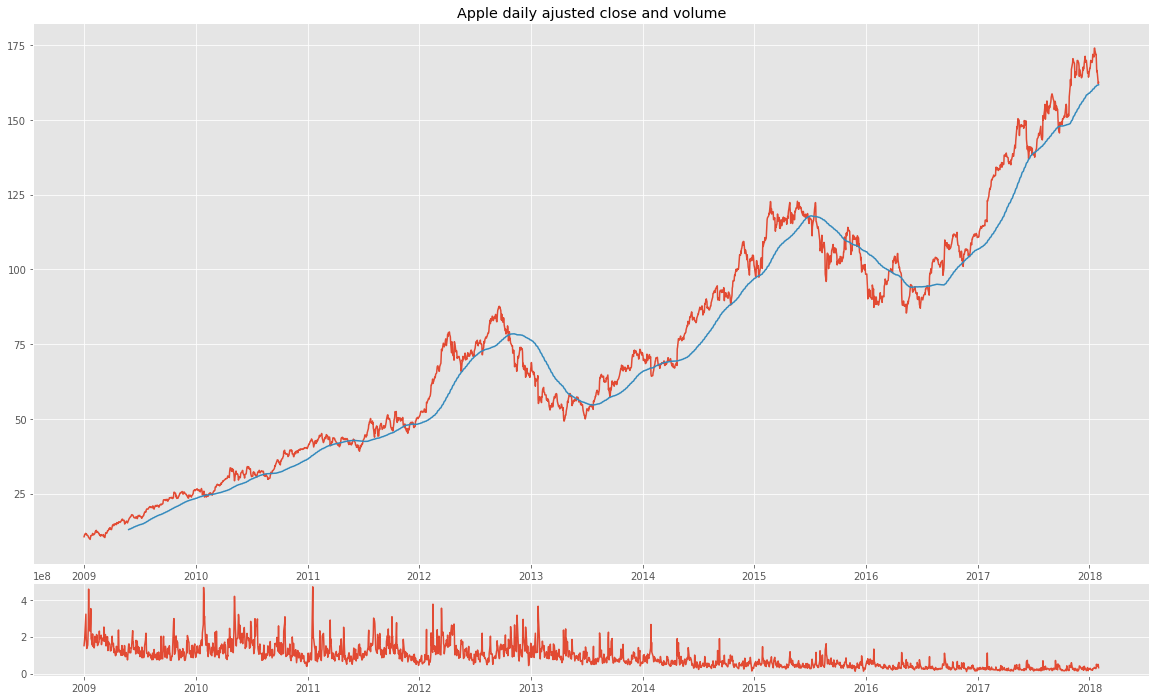

In [28]:
fig = plt.figure(figsize=(20,12))
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1,  title="Apple daily ajusted close and volume")
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=5, colspan=1, sharex=ax1)

ax1.plot(aapl.index, aapl["Adj Close"])
ax1.plot(aapl.index, aapl["100MA"])
ax2.plot(aapl.index, aapl["Volume"])

plt.show()

The 100 day MA is a simple way of viewing the trend of the price. Since its the average of the past 100 values, it isn't the most accurate representation of the current state of the price process, but a smoothing of the past trend. Alternatives to the simple MA is a weighted MA, a weighted average giving a higher weight to more recent observations. A popular version of this is the exponential moving average (EMA). The EMA uses an exponential decaying weighing. Since old observations will have a very low weighing, we can use the entire dataset to calculate the EMA for each day.

### Exponential moving average:

Let $EMA_t$ and $p_t$ be the exponential moving average and price at time t respectively. Let $\alpha$ be a factor between 0 and 1 that determines how fast the weighting decrease. A higher $\alpha$ gives a higher weighting to the more recent observations, and a lower weighting to the older ones, while a small $\alpha$ gives a more equal weighting, where $\alpha = 0$ is just the simple moving average.  

The formula is given by  

$EMA_t = \large{\frac{p_t + (1-\alpha) p_{t-1} + (1-\alpha)^2 p_{t-2} + \dots (1-\alpha)^{t-1} p_{1}}{1+(1-\alpha)+(1-\alpha)^2+\dots}}$  

Research has shown that an alpha of of 0.9 is a good starting point for analysis.

# use the moving average to create a simple trading strategy

### Buy and hold when the moving average slopes up, sell and hold bond or short when it slopes down

In [38]:
aapl_100MA.dropna(inplace=True)

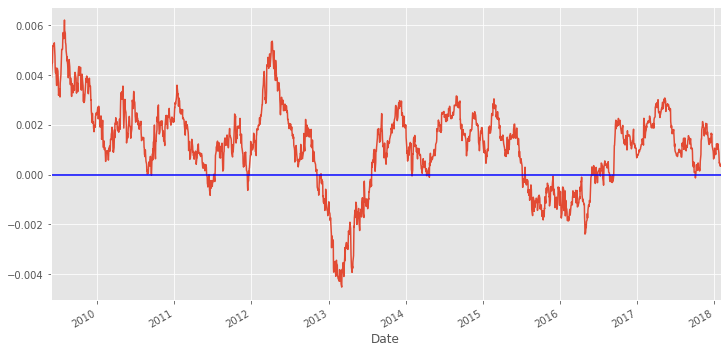

In [39]:
# Calculate the return series of the 100 day moving average
# when this goes negative, the slope of the MA will be negative
aapl_100MA_ret = (aapl_100MA - aapl_100MA.shift())/aapl_100MA.shift()
aapl_100MA_ret.dropna(inplace=True)
ax = aapl_100MA_ret.plot(figsize=(12,6))
ax.axhline(y=0, color="blue")
plt.show()

### Repeating the previous DataFrame manipulation steps, and adding a new column of the price process of the long/short strategy, where we go long if the 100 day moving average is sloping upwards, and go short if the 100 day MA is sloping downwards

In [41]:
aapl = web.get_data_yahoo('AAPL', 
                          start=datetime.datetime(2009, 1, 1), 
                          end=datetime.datetime(2018, 1, 31))

aapl = aapl[["Adj Close", "Volume"]]
aapl["Return"] = (aapl["Adj Close"] - aapl["Adj Close"].shift())/aapl["Adj Close"].shift()
aapl_100MA = aapl["Adj Close"].rolling(window=100).mean()
aapl["100MA"] = aapl_100MA

# Add a new column to aapl that gives the position we should hold
aapl = aapl.dropna()

aapl_100MA_ret = (aapl_100MA - aapl_100MA.shift())/aapl_100MA.shift()
aapl_100MA_ret.dropna(inplace=True)
aapl["100MA return"] = aapl_100MA_ret


# True if 100MA slopes down
aapl["Position"] = "nan" 
# add long short strategy column
aapl["longshort"] = 0
aapl["longshort"][0] = aapl["Adj Close"][0]
# add long hold strategy column
aapl["longcash"] = 0
aapl["longcash"][0] = aapl["Adj Close"][0]
#aapl = aapl[1:]

# change position when the moving average goes from positive to negative, or negative to positive.
x = 0

# Long/short strategy will add up the return of the price if we are long, and subtract the returns when we are short
# long/cash strategy will go long if the 100 day moving average is sloping upwards, and sell and hold cash if the 100 day MA
# is sloping downwards
count = 1
aapl_diff = aapl["Adj Close"].diff()
for i in range(0,aapl.shape[0]):
    if aapl["100MA return"][i] <= x:
        aapl.Position.iloc[[i]] = "Short"
        if count < aapl.shape[0]:
            aapl.longshort.iloc[[i+1]] = aapl["longshort"][i] - aapl_diff[i+1]
            aapl.longcash.iloc[[i+1]] = aapl["longcash"][i]
    else:
        aapl.Position.iloc[[i]] = "Long"
        if count < aapl.shape[0]:
            aapl.longshort.iloc[[i+1]] = aapl["longshort"][i] + aapl_diff[i+1]
            aapl.longcash.iloc[[i+1]] = aapl["longcash"][i] + aapl_diff[i+1]
    count = count + 1

aapl

,Adj Close,Volume,Return,Adj Close diff,100MA,100MA return,Position,longshort,longcash
Date,,,,,,,,,
2009-05-26,16.255972,159231800.0,0.067592,16.255972,13.017779,NaN,Long,16.000000,16.000000
2009-05-27,16.538132,161605500.0,0.017357,16.538132,13.077070,0.004555,Long,16.282160,16.282160
2009-05-28,16.789219,121888200.0,0.015182,16.789219,13.132160,0.004213,Long,16.533247,16.533247
2009-05-29,16.881203,114133600.0,0.005479,16.881203,13.183409,0.003903,Long,16.625231,16.625231
2009-06-01,17.321232,113124900.0,0.026066,17.321232,13.240997,0.004368,Long,17.065260,17.065260
...,...,...,...,...,...,...,...,...,...
2018-01-25,166.083679,41529000.0,-0.017851,166.083679,161.460523,0.000463,Long,185.132318,175.480013
2018-01-26,166.471924,39143000.0,0.002338,166.471924,161.538636,0.000484,Long,185.520563,175.868258
2018-01-29,163.026215,50640400.0,-0.020698,163.026215,161.601343,0.000388,Long,182.074854,172.422548


### Plot the three price processes

* 1: Buy and hold apple stock through the entire period
* 2: Buy and hold when the 100d MA is sloping upwards, sell and hold cash when it is sloping downwards
* 3: Buy and hold when the 100d MA is sloping upwards, sell and short when it is sloping downwards

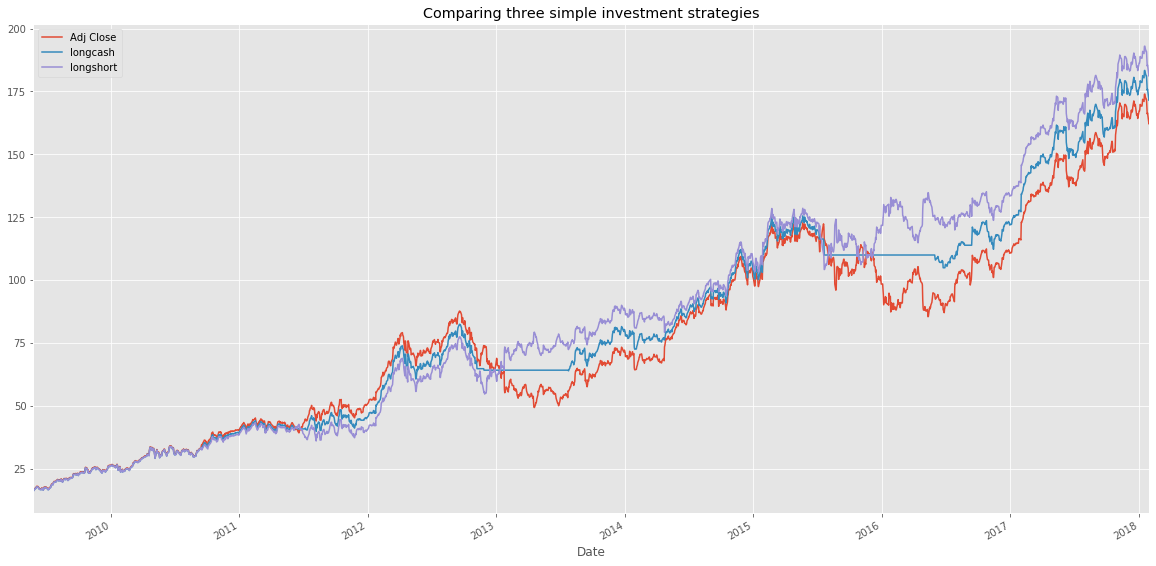

In [47]:
aapl[["Adj Close", "longcash", "longshort"]].plot(figsize=(20,10), title="Comparing three simple investment strategies")

### Write a function that takes in quandl data as well as a general one that does the same calculations as above, creating a strategy based on the slope of the moving average, we also include the option of the exponential moving average, the option of choosing which slope should trigger a change in position, and how many days lookback we want in the moving average

These functions can be optimized and generalized more

In [66]:
# function where we import from quandl using 
def investment_strategies_quandl(myquandlkey, ticker, start, end, x=0, MA_function="simple_moving_average", days=100, **kwargs):
    """
    Insert ticker, start time, end time, the function will use the quandl API to extract a DataFrame of the given ticker
    and the given time frame. It will then create three investment strategies. One buy and hold, one buy and hold when
    the 100 day MA is sloping upward, and short sell when it is sloping downward.
    The third strategy will hold cash instead of short selling.
    x: long/short trigger point
    """
    try:
        df = quandl.get(f"WIKI/{ticker}", start_date=start, end_date=end, api_key=myquandlkey)
    except:
        print("Please enter a valid quandl API key")
    df = df[["Adj. Close", "Adj. Volume"]]
    df["Return"] = (df["Adj. Close"] - df["Adj. Close"].shift())/df["Adj. Close"].shift()
    
    if MA_function=="ewm":
        df["MA"] = df["Adj. Close"].ewm(span=days).mean()
    else:
        df["MA"] = simple_moving_average(df[["Adj. Close"]], days=days)

    # Add a new column to aapl that gives the position we should hold
    df = df.dropna()

    df_MA_ret = (df["MA"] - df["MA"].shift())/df["MA"].shift()
    df_MA_ret.dropna(inplace=True)
    df["MA change"] = df_MA_ret

    # True if 100MA slopes down
    df["Position"] = "nan" 
    # add long short strategy column
    df["longshort"] = 0
    df["longshort"][0] = df["Adj. Close"][0]
    # add long hold strategy column
    df["longcash"] = 0
    df["longcash"][0] = df["Adj. Close"][0]

    # Long/short strategy will add up the return of the price if we are long, and subtract the returns when we are short
    # long/cash strategy will go long if the 100 day moving average is sloping upwards, and sell and hold cash if the 100 day MA
    # is sloping downwards
    count = 1
    df_diff = df["Adj. Close"].diff()
    for i in range(0,df.shape[0]):
        if df["MA change"][i] <= x:
            df.Position.iloc[[i]] = "Short"
            if count < df.shape[0]:
                df.longshort.iloc[[i+1]] = df["longshort"][i] - df_diff[i+1]
                df.longcash.iloc[[i+1]] = df["longcash"][i]
        else:
            df.Position.iloc[[i]] = "Long"
            if count < df.shape[0]:
                df.longshort.iloc[[i+1]] = df["longshort"][i] + df_diff[i+1]
                df.longcash.iloc[[i+1]] = df["longcash"][i] + df_diff[i+1]
        count = count + 1
        
    r1 = (df["Adj. Close"] - df["Adj. Close"].shift())/df["Adj. Close"].shift()
    r2 = (df["longcash"] - df["longcash"].shift())/df["longcash"].shift()
    r3 = (df["longshort"] - df["longshort"].shift())/df["longshort"].shift()
    df_return = pd.DataFrame({"return":r1, "return longcash":r2, "return longshort":r3})
    df_return.dropna(inplace=True)
    
    df.rename(columns={"Adj. Close":"Price", "Adj. Volume":"Volume"})
    
    return (df, df_return)

# function where we use our own DataFrame
def investment_strategies(df, ticker, start, end, x=0, MA_function="simple_moving_average", days=100, **kwargs):
    """
    Insert ticker, start time, end time, and a DataFrame. The DataFrame needs to contain a price column names "Price"
    It will then create three investment strategies. One buy and hold, one buy and hold when
    the 100 day MA is sloping upward, and short sell when it is sloping downward.
    The third strategy will hold cash instead of short selling.
    x: long/short trigger point
    """
    df = df[start:end]
    df["Return"] = (df["Price"] - df["Price"].shift())/df["Price"].shift()
    
    if MA_function=="ewm":
        df["MA"] = df["Price"].ewm(span=days).mean()
    else:
        df["MA"] = simple_moving_average(df[["Price"]], days)
        
    # Add a new column to aapl that gives the position we should hold
    df = df.iloc[days:]
    
    df_MA_ret = (df["MA"] - df["MA"].shift())/df["MA"].shift()
    df_MA_ret.dropna(inplace=True)
    df["MA change"] = df_MA_ret


    # True if 100MA slopes down
    df["Position"] = "nan" 
    # add long short strategy column
    df["longshort"] = 0
    df["longshort"][0] = df["Price"][0]
    # add long hold strategy column
    df["longcash"] = 0
    df["longcash"][0] = df["Price"][0]


    # Long/short strategy will add up the return of the price if we are long, and subtract the returns when we are short
    # long/cash strategy will go long if the 100 day moving average is sloping upwards, and sell and hold cash if the 100 day MA
    # is sloping downwards
    count = 1
    df_diff = df["Price"].diff()
    for i in range(0,df.shape[0]):
        if df["MA change"][i] <= x:
            df.Position.iloc[[i]] = "Short"
            if count < df.shape[0]:
                df.longshort.iloc[[i+1]] = df["longshort"][i] - df_diff[i+1]
                df.longcash.iloc[[i+1]] = df["longcash"][i]
        else:
            df.Position.iloc[[i]] = "Long"
            if count < df.shape[0]:
                df.longshort.iloc[[i+1]] = df["longshort"][i] + df_diff[i+1]
                df.longcash.iloc[[i+1]] = df["longcash"][i] + df_diff[i+1]
        count = count + 1
        
    r1 = df["Return"]
    r2 = (df["longcash"] - df["longcash"].shift())/df["longcash"].shift()
    r3 = (df["longshort"] - df["longshort"].shift())/df["longshort"].shift()
    df_return = pd.DataFrame({"return":r1, "return longcash":r2, "return longshort":r3})
    df_return.dropna(inplace=True)
    
    return (df, df_return)


def simple_moving_average(price, days=100):
    """
    Calculate the simple moving average on a price series, specify the window length, using 100 days default
    """
    df_MA = price.rolling(window=days).mean()
    return df_MA

def exponential_moving_average(price, alpha=0.9):
    """
    Calculate the exponential moving average on a price series, specify the decay factor alpha
    """
    weighted_sum = [0]
    weighted_count = [0]
    EMA = [price.iloc[0][0]]
    for time in range(1,len(price)):
        weighted_sum.append(price.iloc[time][0] + (1-alpha)*weighted_sum[time-1])
        weighted_count.append(1+(1-alpha)*weighted_count[time-1])
        EMA.append(weighted_sum[time]/weighted_count[time])
    return EMA

### Create companion plotting functions for the two strategy functions above

In [ ]:
def plot_investment_strategies_quandl(df, df_return, ticker, start, end):
    ax = df[["Adj. Close", "longcash", "longshort"]].plot(figsize=(20,10))
    ax.set_title("Comparing three simple investment strategies for " + ticker + " between " + start + " and " + end)
    plt.show()
    
    # view summary statistics of the return series of the three strategies
    table = erk.summary_stats(df_return, ppp=252)
    return table

def plot_investment_strategies(df, df_return, ticker, start, end):
    ax = df[["Price", "longcash", "longshort"]].plot(figsize=(20,10))
    ax.set_title("Comparing three simple investment strategies for " + ticker + " between " + start + " and " + end)
    plt.show()
    
    # view summary statistics of the return series of the three strategies
    table = erk.summary_stats(df_return, ppp=252)
    return table

### Use the generic function for Apple

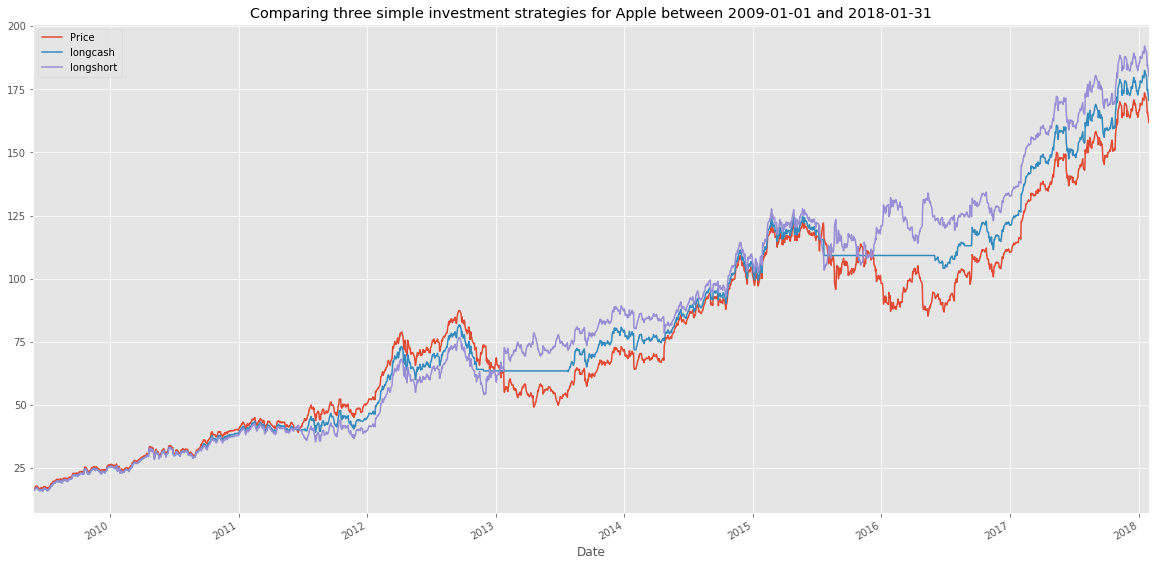

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
return,0.299273,0.251965,-0.087173,7.292183,0.023953,0.034804,1.037683,-0.437972
return longcash,0.314208,0.212025,0.306206,7.975964,0.018264,0.030429,1.301559,-0.226120
return longshort,0.322538,0.249932,0.418685,8.111262,0.021109,0.034449,1.136508,-0.296326


In [67]:
aapl = web.get_data_yahoo('AAPL', 
                          start=datetime.datetime(2009, 1, 1), 
                          end=datetime.datetime(2018, 1, 31))

aapl.rename(columns={"Adj Close": "Price"}, inplace=True)

ticker = "Apple"
start = "2009-01-01"
end = "2018-01-31"

df_new, df_return = investment_strategies(df = aapl, ticker=ticker, start=start, end=end)
plot_investment_strategies(df=df_new, df_return=df_return, ticker=ticker, start=start, end=end)

### Use the generic function for the S&P500

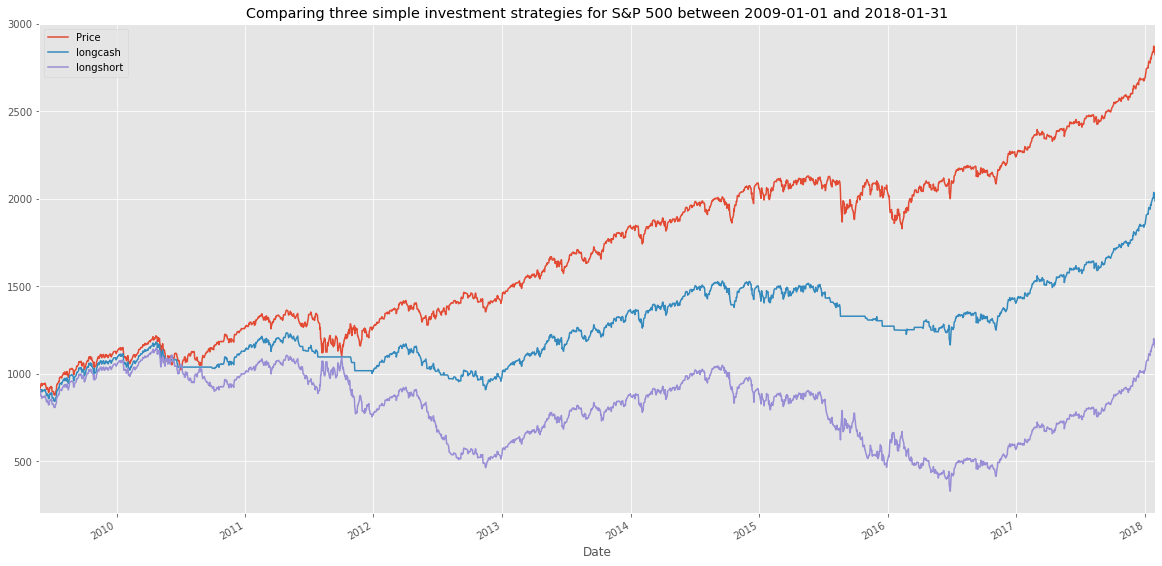

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
return,0.141916,0.148931,-0.373074,7.223032,0.015028,0.022776,0.729656,-0.193882
return longcash,0.096634,0.140618,-0.461740,6.434417,0.014675,0.022416,0.460109,-0.264260
return longshort,0.029775,0.318786,-0.119354,9.356408,0.030805,0.047802,-0.000703,-0.713084


In [41]:
SP500 = web.get_data_yahoo('^GSPC', 
                          start=datetime.datetime(2009, 1, 1), 
                          end=datetime.datetime(2018, 1, 31))

SP500.rename(columns={"Adj Close": "Price"}, inplace=True)

ticker = "S&P 500"
start = "2009-01-01"
end = "2018-01-31"

df_new, df_return = investment_strategies(df=SP500, ticker=ticker, start=start, end=end)
plot_investment_strategies(df=df_new, df_return=df_return, ticker=ticker, start=start, end=end)

As we can see, our strategies doesn't work well here. A 100 day simple moving average doesn't seem to be a very good tracker of the trend. Remember, the 100 day MA captures the trend 100 day in the past. One might think using a shorter timeframe can solve this, the problem with this is that we then capture the short term trend, which is more volatile. This can lead to us selling because of a small drawdown that quickly bounces back up. 

### Look at the Moving average plot of the S&P500

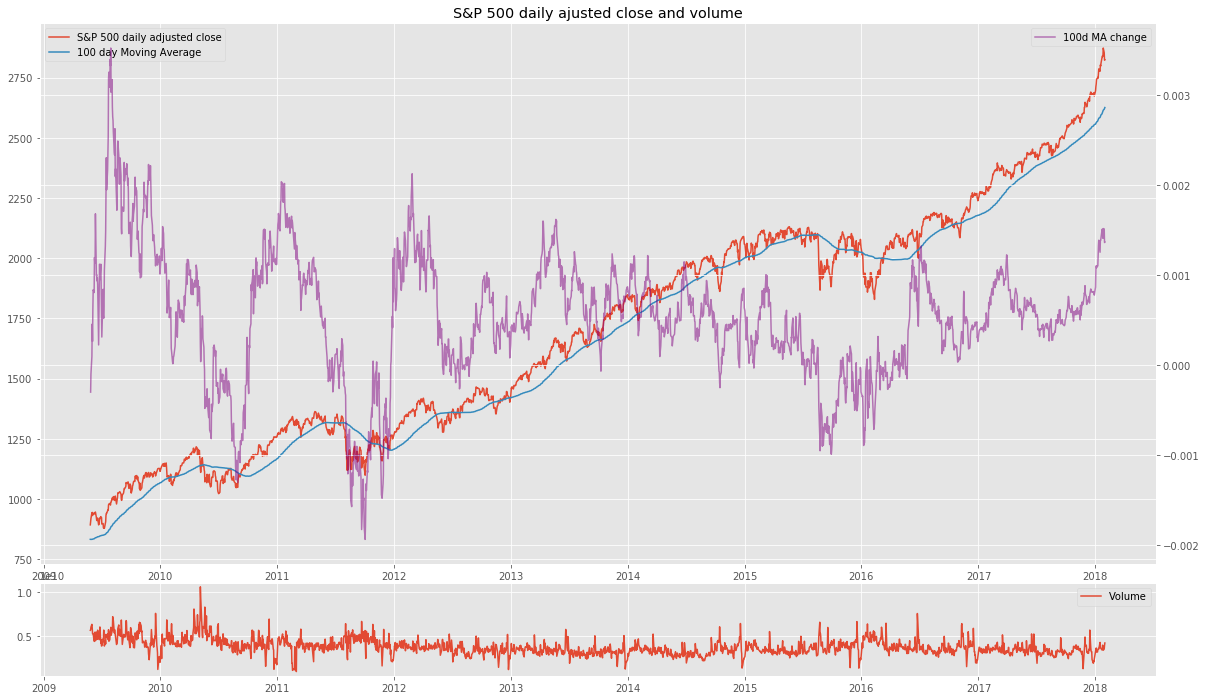

In [33]:
def moving_average_plot(stock_name, df_new, ma_type):
    """
    Plots the moving average toghether with the moving average change and the price process
    Columns called Price, MA, MA change, Volume
    """
    fig = plt.figure(figsize=(20,12))
    ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1,  title=f"{ticker} daily ajusted close and volume")
    ax=ax1.twinx()
    ax2 = plt.subplot2grid((6,1), (5,0), rowspan=5, colspan=1, sharex=ax1)

    ax1.plot(df_new.index, df_new["Price"])
    ax1.plot(df_new.index, df_new["MA"])
    ax.plot(df_new.index, df_new["MA change"], color = "purple", alpha=0.5)
    ax2.plot(df_new.index, df_new["Volume"])
    ax1.legend([f"{ticker} daily adjusted close", f"{ma_type}"])
    ax.legend(["MA change"])
    ax2.legend(["Volume"])

    plt.show()

moving_average_plot(stock_name="S&P 500", df_new=df_new, ma_type="100 day Moving Average")

### Strategies on Apple and S&P500 using Exponential Moving Average

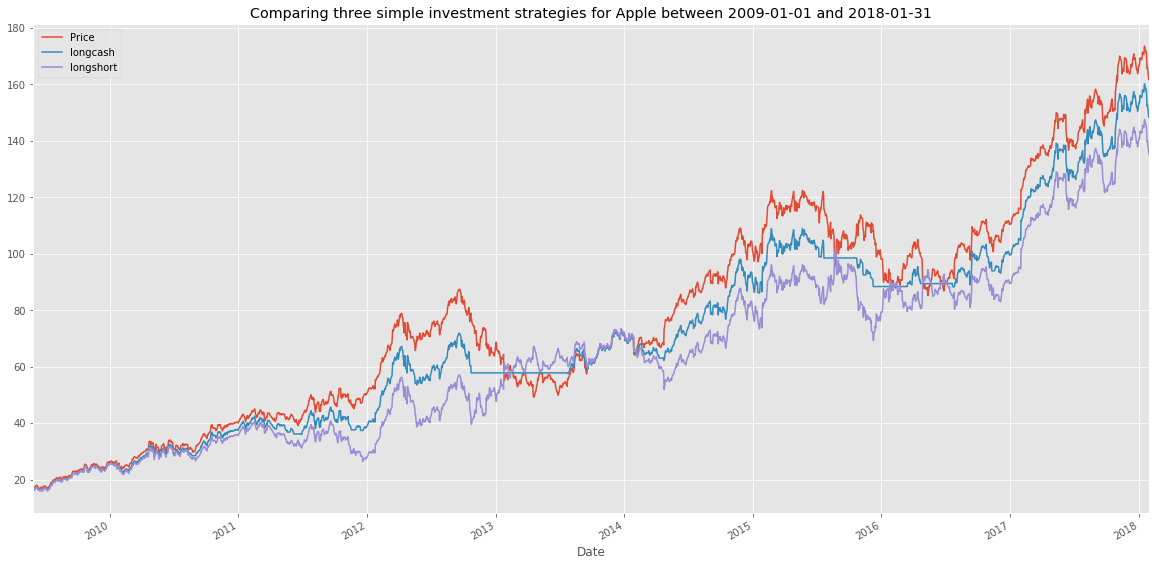

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
return,0.299273,0.251965,-0.087173,7.292183,0.023953,0.034804,1.037683,-0.437972
return longcash,0.292801,0.226978,0.257933,7.910144,0.019909,0.032836,1.124236,-0.203826
return longshort,0.279122,0.309084,0.303329,8.234026,0.027084,0.043751,0.782606,-0.352104


In [68]:
aapl = web.get_data_yahoo('AAPL', 
                          start=datetime.datetime(2009, 1, 1), 
                          end=datetime.datetime(2018, 1, 31))

aapl.rename(columns={"Adj Close": "Price"}, inplace=True)

ticker = "Apple"
start = "2009-01-01"
end = "2018-01-31"

df_new, df_return = investment_strategies(df=aapl, ticker=ticker, start=start, end=end, MA_function="ewm")
plot_investment_strategies(df=df_new, df_return=df_return, ticker=ticker, start=start, end=end)

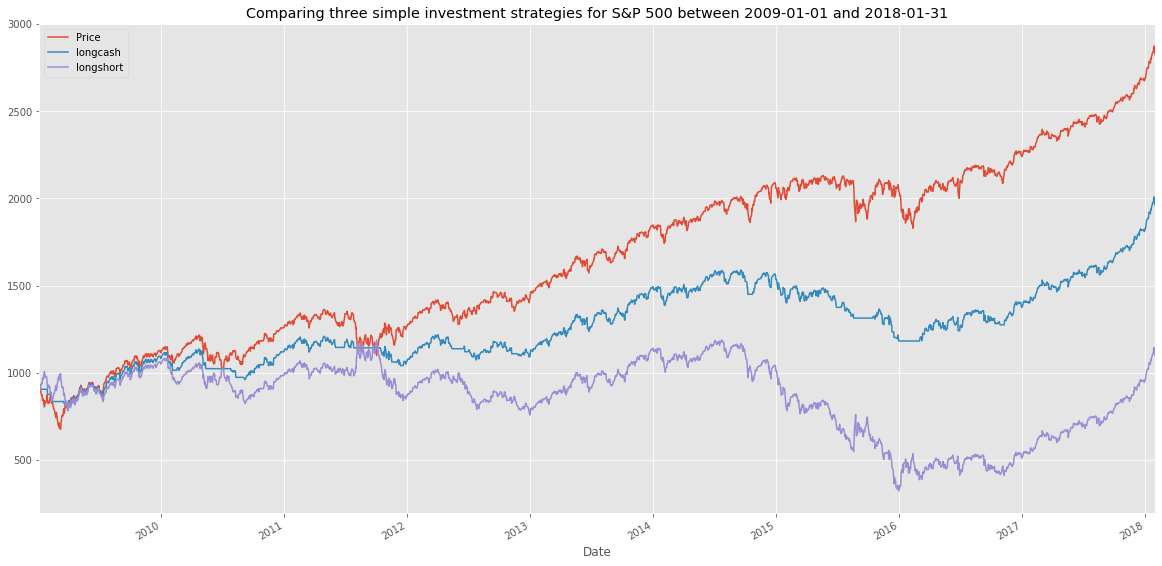

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
return,0.130709,0.165168,-0.199610,8.273904,0.016044,0.025479,0.592040,-0.276206
return longcash,0.086104,0.143291,-0.507488,6.452125,0.015105,0.023102,0.380174,-0.255848
return longshort,0.018663,0.321285,0.025838,9.558907,0.030177,0.048606,-0.034280,-0.729116


In [45]:
SP500 = web.get_data_yahoo('^GSPC', 
                          start=datetime.datetime(2009, 1, 1), 
                          end=datetime.datetime(2018, 1, 31))

SP500.rename(columns={"Adj Close": "Price"}, inplace=True)

ticker = "S&P 500"
start = "2009-01-01"
end = "2018-01-31"

df_new, df_return = investment_strategies(df=SP500, ticker=ticker, start=start, end=end, MA_function="ewm")
plot_investment_strategies(df=df_new, df_return=df_return, ticker=ticker, start=start, end=end)

### Strategies on Apple price using Exponential Moving Average and x=-0.001

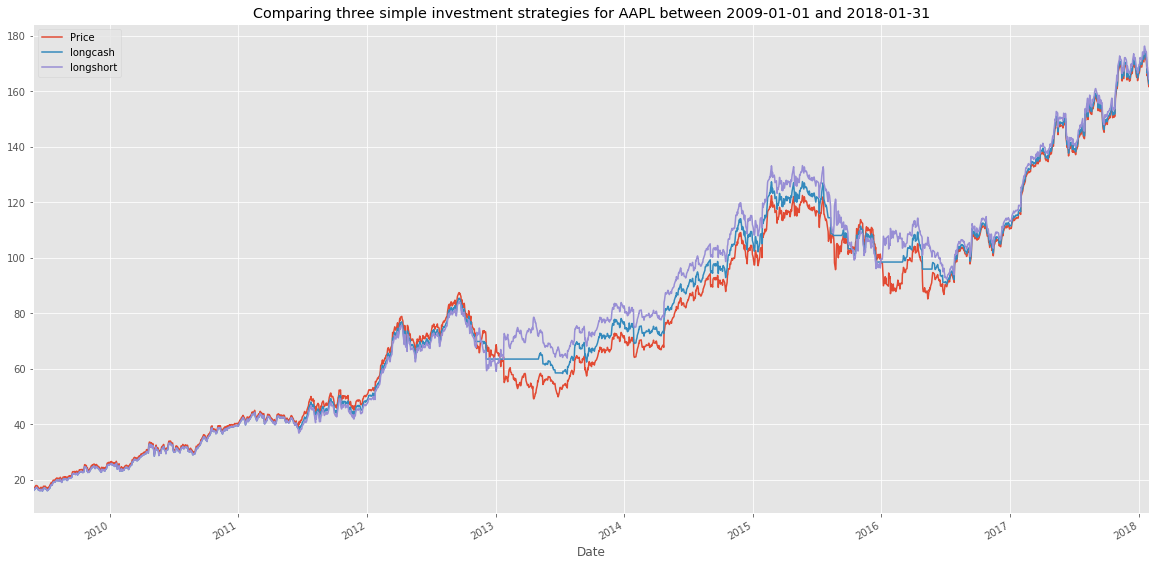

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
return,0.299273,0.251965,-0.087173,7.292183,0.023953,0.034804,1.037683,-0.437972
return longcash,0.307073,0.225047,0.233029,7.056608,0.020036,0.031441,1.195456,-0.320273
return longshort,0.308677,0.245544,0.385953,7.534242,0.021094,0.033312,1.102008,-0.307192


In [69]:
ticker = "AAPL"
start = "2009-01-01"
end = "2018-01-31"

df_new, df_return = investment_strategies(df = aapl, ticker=ticker,
                                          start=start, end=end, MA_function="ewm", x=-0.001)

plot_investment_strategies(df=df_new, df_return=df_return, ticker=ticker, start=start, end=end)

### Strategies on Apple price using Exponential Moving Average and x=0.001

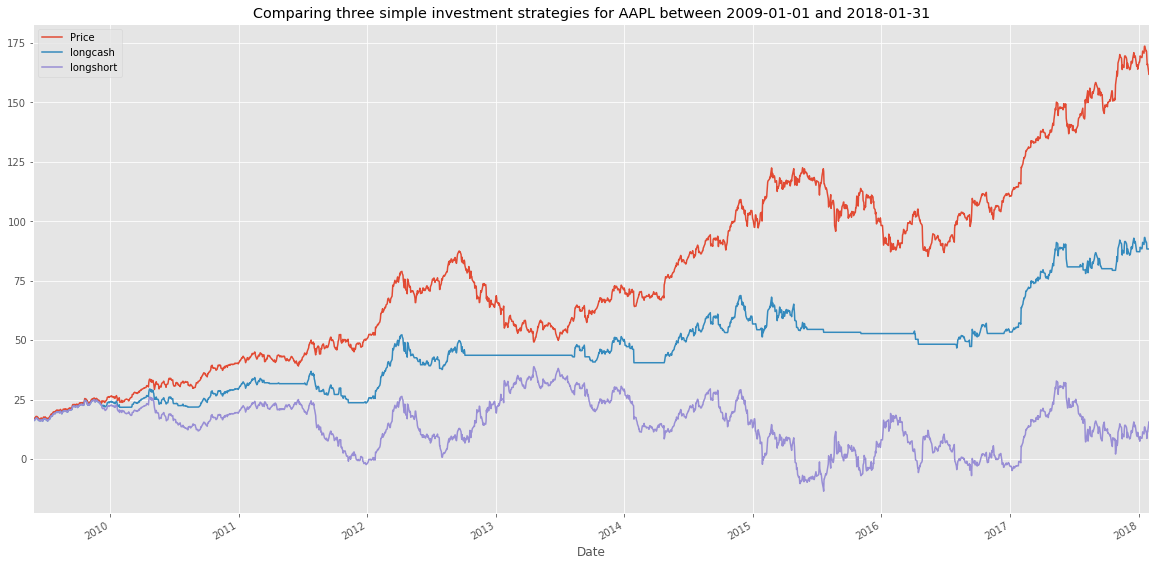

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
return,0.299273,0.251965,-0.087173,7.292183,0.023953,0.034804,1.037683,-0.437972
return longcash,0.217757,0.267033,0.285082,12.717028,0.022053,0.041702,0.682712,-0.360729
return longshort,-0.005656,125.212544,-16.039609,1137.851036,-169.674792,5.065271,-0.000336,-1.347696


In [70]:
ticker = "AAPL"
start = "2009-01-01"
end = "2018-01-31"

df_new, df_return = investment_strategies(df = aapl, ticker=ticker,
                                                 start=start, end=end, MA_function="ewm", x=0.001)

plot_investment_strategies(df=df_new, df_return=df_return, ticker=ticker, start=start, end=end)

### Plot price process of Apple, EMA, and EMA slope

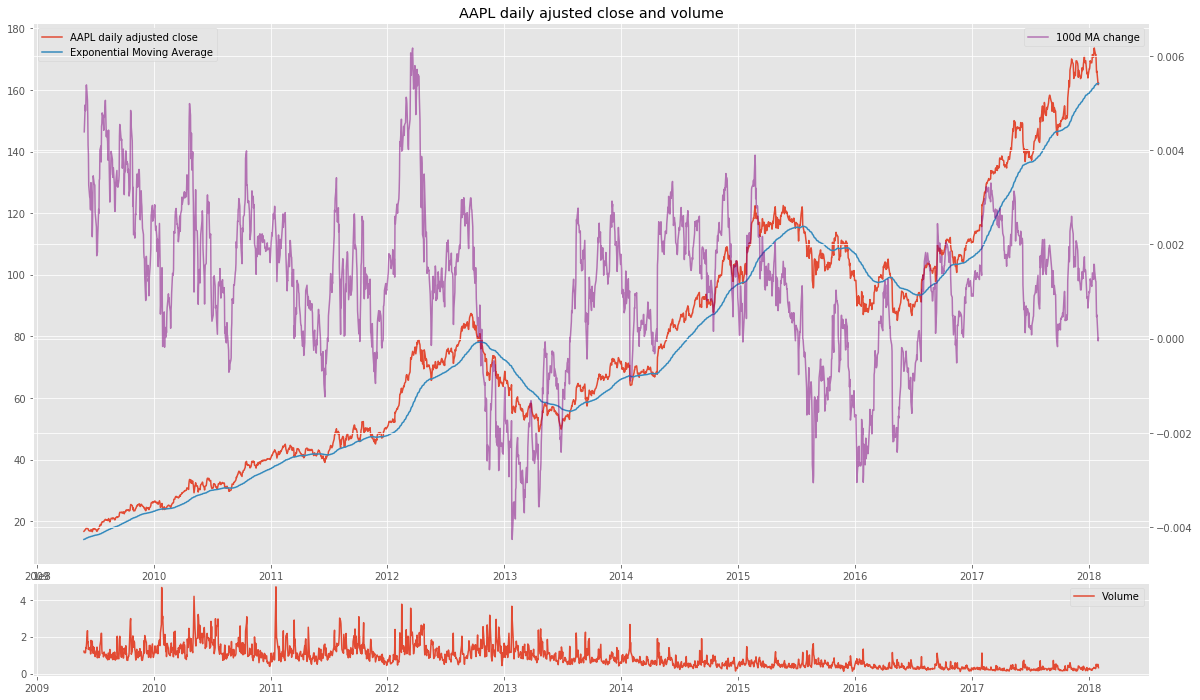

In [71]:
moving_average_plot(stock_name="Apple", df_new=df_new, ma_type="Exponential Moving Average")

### Compare the 100 day simple moving average with the exponential moving average

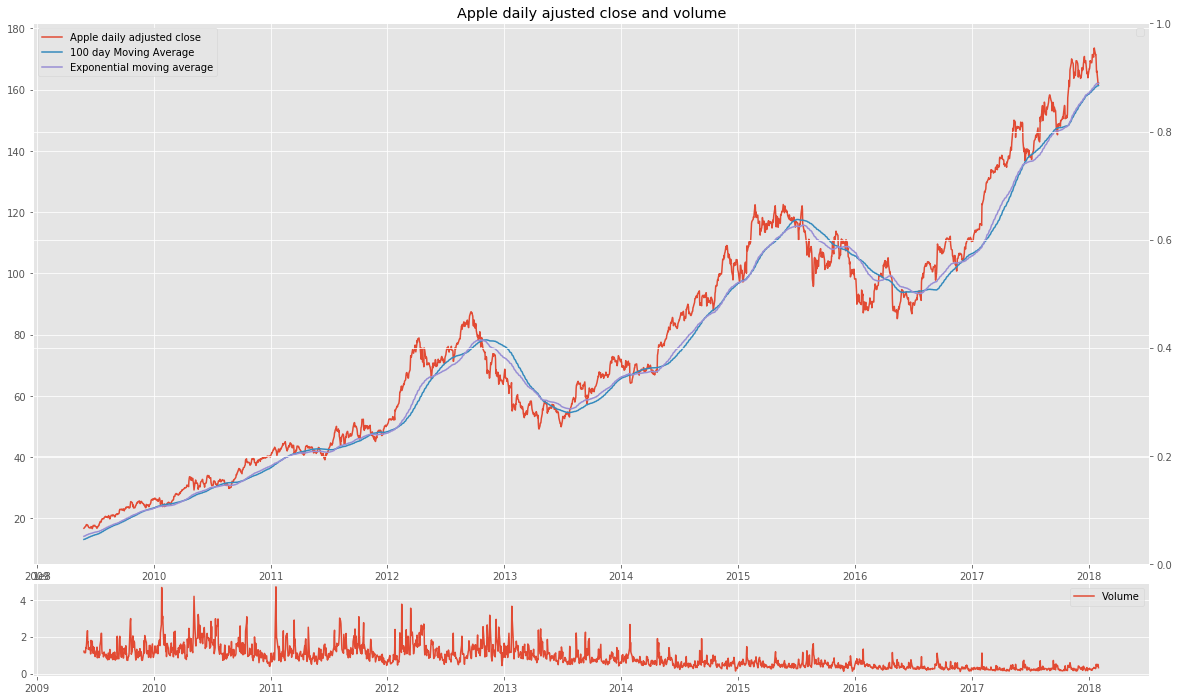

In [72]:
df_new, df_return = investment_strategies(df = aapl, ticker=ticker,
                                                 start=start, end=end, MA_function="simple MA")

df_new2, df_return2 = investment_strategies(df = aapl, ticker=ticker,
                                                 start=start, end=end, MA_function="ewm")

fig = plt.figure(figsize=(20,12))
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1,  title="Apple daily ajusted close and volume")
ax=ax1.twinx()
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=5, colspan=1, sharex=ax1)
ax1.plot(df_new.index, df_new["Price"])
ax1.plot(df_new.index, df_new["MA"])
ax1.plot(df_new2.index, df_new2["MA"])
ax2.plot(df_new.index, df_new["Volume"])
ax1.legend(["Apple daily adjusted close", "100 day Moving Average", "Exponential moving average"])
ax2.legend(["Volume"])

plt.show()

The EMA turns a bit faster than the 100 day simple MA, but they are fairly similar.

# Further exploration:

For further work we want to optimize the timing of long and short. In general We don't want to change position more frequently than weekly or monthly due to transaction costs. We can use cross validation modified for time series to backtest.

* Use past volatility to determine the market condition
* Vary the time frame of the moving average lookback
* Use cross validation to find an optimal slope of the MA to trigger a change in position. 
* Combine other factors such as market condition, 
* Explore Moving Average Convergence Divergence (MACD), which looks at the relationship between two moving averages. See if this is a better option for tracking momentum in the market.

### Since we included the volume data, let's look for correlation over time between the price and the volume, then test for stationarity

In [ ]:
# rolling correlation between adjusted close and adjusted volume
# first normalize volume to be equal to Adj close at the starting time
factor = aapl["Volume"]/aapl["Adj Close"]
rolling_corr = aapl["Adj Close"].rolling(window=30).corr(aapl["Volume"]/factor[0])
rolling_corr.plot(figsize=(20,5))


import statsmodels
from statsmodels.tsa.stattools import adfuller
def check_for_stationarity(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print("p-value =", pvalue, ' The series is likely stationary.')
        return True
    else:
        print("p-value =", pvalue, ' The series is likely non-stationary.')
        return False
    
check_for_stationarity(rolling_corr.dropna())

I don't know if this has any merit, but I think it shows that daily volume isn't good for predicting price. When the correlation is highly negative or positive there is some pattern, but as we can see, it changes too much over time and is very noisy.

In [2]:
# import data splitter
from sklearn.model_selection import TimeSeriesSplit

In [3]:
# Get the data
start = "2009-01-01"
end = "2018-01-31"
df = quandl.get("WIKI/AAPL", start_date=start, end_date=end, api_key=myquandlkey)

In [99]:
# X will be the index, time
X = df.index
# y is the prices
y = df["Adj. Close"]

# choose number of splits to be the number of years we are analyzing
number_of_splits = round(df.shape[0]/252)

# define object and split the data
tscv = TimeSeriesSplit(max_train_size=None, n_splits=number_of_splits)
X_train = []
X_test = []
y_train = []
y_test = []
for train_index, test_index in tscv.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train.append((X[train_index]))
    X_test.append((X[test_index]))
    y_train.append((y[train_index]))
    y_test.append((y[test_index]))

In [218]:
X_train_start = [str(X_train[i][0].date()) for i in range(0,number_of_splits)]
X_train_end = [str(X_train[i][-1].date()) for i in range(0,number_of_splits)]

X_test_start = [str(X_test[i][0].date()) for i in range(0,number_of_splits)]
X_test_end = [str(X_test[i][-1].date()) for i in range(0,number_of_splits)]

### Run strategy on all training sets for different values of x(long to short), and choose the one that minimize test error

In [233]:
X = np.linspace(-0.003, 0.003, 61)
ticker = "aapl"
df.rename(columns={"Adj. Close": "Price"}, inplace=True)


average_training_sharps = []
average_testing_sharps = []
count = 0
for x in X:
    # training
    X_train_sharp = []
    for start, end in zip(X_train_start, X_train_end):
        df_new, df_return = investment_strategies(df=df, ticker=ticker, start=start, end=end, x=x, MA_function="ewm")

        # calculate the return, volatility, to find sharp.
        # use cross validation to find which value of X maximizes sharp
        ret = erk.annualize_rets(df_return[["return longshort"]], periods_per_year=252)
        vol = erk.annualize_vol(df_return[["return longshort"]], periods_per_year=252)        
        X_train_sharp.append((ret-0.02)/vol)
    average_training_sharps.append(np.array(X_train_sharp).sum()/number_of_splits)
    
    X_test_sharp = []
    for start, end in zip(X_test_start, X_test_end):
        df_new, df_return = investment_strategies(df=df, ticker=ticker, start=start, end=end, x=x)
        # calculate the return, volatility, to find sharp.
        # use cross validation to find which value of X maximizes sharp
        ret = erk.annualize_rets(df_return[["return longshort"]], periods_per_year=252)
        vol = erk.annualize_vol(df_return[["return longshort"]], periods_per_year=252)        
        X_train_sharp.append((ret-0.02)/vol)
    average_testing_sharps.append(np.array(X_test_sharp).sum()/number_of_splits)
    count = count + 1
    print(count,"/",len(X))

### Plot the training sharpe ratios

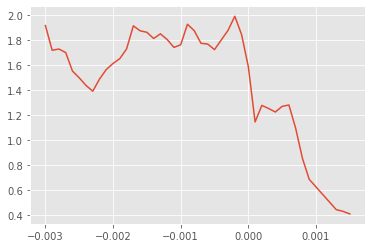

In [237]:
import seaborn as sns
sns.lineplot(x=X, y=average_training_sharps)

-0.001 may to be a good starting point for further analysis